# Iowa Liquor Market Research for New Store Locations

Scenario involves a liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model that fits the data, so that his team can evaluate potential locations for a new storefront.

The data is from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy),which is in csv format. The data is 10% sample of the total data.

## The following steps are taken in this analysis

* Importing and loading libraries

* Tidying the Data/Data Munging

* Exploratory Data Analysis & Visualization

* Regression Analysis


## Importing Dataset and Data Munging

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
## Load the data into a DataFrame
df = pd.read_csv('../Resources/Iowa_Liquor_sales_sample_10pct.csv')

### Filling in missing values in County Names as well as misspelled city names

In [3]:
#fixing missing county names
cc = df.set_index('City')['County'].to_frame()
cc.dropna(inplace=True)
undefined = pd.DataFrame([['Wayne'],['Polk'],['Fremont']], columns=['County'], index=['SEYMOUR', 'RUNNELLS', 'TABOR'])
df2 = pd.concat([cc, undefined])

def get_county(city):
    return df2.T[city].values[0][0]


In [4]:
citys_wo_county = df[pd.isnull(df["County"])]["City"].to_frame()
for row in citys_wo_county.index:
    df.set_value(row, 'County', get_county(citys_wo_county.ix[row]['City']))

In [5]:
#fixing spelling errors
df['City'] = df['City'].apply(lambda x: x.replace('MOUNT PLEASANT','MT PLEASANT'))
df['City'] = df['City'].apply(lambda x: x.replace('OTTUWMA','OTTUMWA'))
df['City'] = df['City'].apply(lambda x: x.replace('MOUNT VERNON','MT VERNON'))
df['City'] = df['City'].apply(lambda x: x.replace('ARNOLDS PARK','ARNOLD\'S PARK'))
df['City'] = df['City'].apply(lambda x: x.replace('LEMARS','LE MARS'))
df['City'] = df['City'].apply(lambda x: x.replace('LECLAIRE','LE CLAIRE'))
df['City'] = df['City'].apply(lambda x: x.replace('DEWITT','DE WITT'))
df['City'] = df['City'].apply(lambda x: x.replace('GUTTENBURG','GUTTENBERG'))
df['City'] = df['City'].apply(lambda x: x.replace('JEWELL','JEWELL JUNCTION'))
df['City'] = df['City'].apply(lambda x: x.replace('JEWELL JUNCTION JUNCTION','JEWELL JUNCTION'))
df['City'] = df['City'].apply(lambda x: x.replace('KELLOG','KELLOGG'))
df['City'] = df['City'].apply(lambda x: x.replace('KELLOGGG','KELLOGG'))


In [13]:
#There were some values in the County field that did not parse correct. This will fix the issues
df[(df['County']=='W') | (df['County']=='P') | (df['County']=='F')]

,Date,Store Number,City,Zip Code,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)


In [12]:
#setting individual values to correct County
df.ix[46599,'County'] = 'Fremont'
df.ix[50149,'County'] = 'Wayne'
df.ix[89794,'County'] = 'Wayne'
df.ix[120722,'County'] = 'Wayne'
df.ix[131595,'County'] = 'Wayne'
df.ix[140719,'County'] = 'Fremont'
df.ix[156543,'County'] = 'Polk'
df.ix[168748,'County'] = 'Wayne'
df.ix[202083,'County'] = 'Fremont'
df.ix[213206,'County'] = 'Fremont'
df.ix[234840,'County'] = 'Polk'
df.ix[259771,'County'] = 'Wayne'
df[(df['County']=='W') | (df['County']=='P') | (df['County']=='F')]

In [8]:
#County Number is no longer needed, so we can delete the column
del df['County Number']

### Filling in missing values in Category Names

In [14]:
#fixing missing categories
cat = df.set_index('Category')['Category Name'].to_frame()
cat.dropna(inplace=True)
undefined_cats = pd.DataFrame([["Moonshine"],["Reposado"],["Vodka"],["Hennessy"],["Spiced Rum"],["Rum"],["Amaretto"],["Spirit"],["Moonshine"],["Moonshine"],["Rum"]], columns=['Category Name'], index=['1011700.0', '1022200.0', '1032100.0', '1052100.0', '1062400.0', '1062500.0', '1082100.0', '1082200.0', '1091100.0', '1091300.0', '1092100.0'])
all_cats = pd.concat([cat, undefined_cats])

def get_category_name(category):
    return all_cats.T[str(float(category))].values[0]

In [15]:
category_wo_name = df[pd.isnull(df["Category Name"])]["Category"].to_frame()

for row in category_wo_name.index:
    if not np.isnan(category_wo_name.ix[row]['Category']):
        df.set_value(row, 'Category Name', get_category_name(category_wo_name.ix[row]['Category']))

In [16]:

print df.shape

(270955, 17)


### Converting Date field to datetime object

In [17]:
#converting to datetime
df["Date"] = pd.to_datetime(df["Date"])

In [18]:
#deleting the Category column since its no longer needed
del df['Category']

In [19]:
#removing $ and converting to float
df['State Bottle Cost'] = df['State Bottle Cost'].apply(lambda x: str(x).replace('$','')).astype(float)
df['State Bottle Retail'] = df['State Bottle Retail'].apply(lambda x: str(x).replace('$','')).astype(float)
df['Sale (Dollars)'] = df['Sale (Dollars)'].apply(lambda x: str(x).replace('$','')).astype(float)
df['City'] = df['City'].apply(lambda x: x.upper())

#### Constrain the dataframe to 2015

In [20]:
#only using the 2015 year data
df = df[df['Date'].dt.year == 2015]

In [21]:
#creating total cost column
tot_cost = df['Bottles Sold']*df['State Bottle Cost']
insert_totcost = df.columns.get_loc('Sale (Dollars)') + 1
df.insert(insert_totcost,'Total_Cost',tot_cost)

## Exploratory Data Analysis

Exploratory Data Analysis is performed to analyze the data for skewness, as well as build predictors for the target variable.

In [22]:
df.head()

,Date,Store Number,City,Zip Code,County,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Total_Cost,Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,Bremer,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,54.00,9.00,2.38
4,2015-08-18,3654,BELMOND,50421,Wright,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,86.40,21.00,5.55
5,2015-04-20,2569,CEDAR RAPIDS,52402,Linn,AMERICAN DRY GINS,205,31473,New Amsterdam Gin,1750,13.32,19.98,6,119.88,79.92,10.50,2.77
6,2015-08-05,2596,OTTUMWA,52501,Wapello,AMERICAN GRAPE BRANDIES,85,52806,Korbel Brandy,750,6.66,9.99,3,29.97,19.98,2.25,0.59
7,2015-06-25,3456,CLEAR LAKE,50428,Cerro Gordo,CANADIAN WHISKIES,65,10628,Canadian Club Whisky,1750,15.75,23.63,2,47.26,31.50,3.50,0.92


In [23]:
df.describe()

,Store Number,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Total_Cost,Volume Sold (Liters),Volume Sold (Gallons)
count,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000
mean,3578.700216,255.976783,45947.926064,925.621609,9.771547,14.675065,9.950456,130.503332,86.860051,9.087232,2.400800
std,942.194733,141.266301,52563.817681,492.014837,7.021363,10.531652,24.449269,386.612714,256.816527,29.360489,7.756215
min,2106.000000,10.000000,173.000000,50.000000,0.890000,1.340000,1.000000,1.340000,0.890000,0.100000,0.030000
25%,2603.000000,115.000000,26828.000000,750.000000,5.510000,8.270000,2.000000,30.720000,20.430000,1.600000,0.420000
50%,3715.000000,260.000000,38176.000000,750.000000,8.000000,12.300000,6.000000,70.560000,47.040000,5.250000,1.390000
75%,4349.000000,380.000000,64573.000000,1000.000000,11.920000,17.880000,12.000000,135.660000,90.420000,10.500000,2.770000
max,9018.000000,978.000000,995507.000000,6000.000000,425.000000,637.500000,2508.000000,36392.400000,24261.600000,2508.000000,662.540000


Bottles Sold, Sale (Dollars) are skewed. Plotting Histiograms show that we should to restrict to Bottles Sold per transaction to 25 and less. This will eliminate outliers.

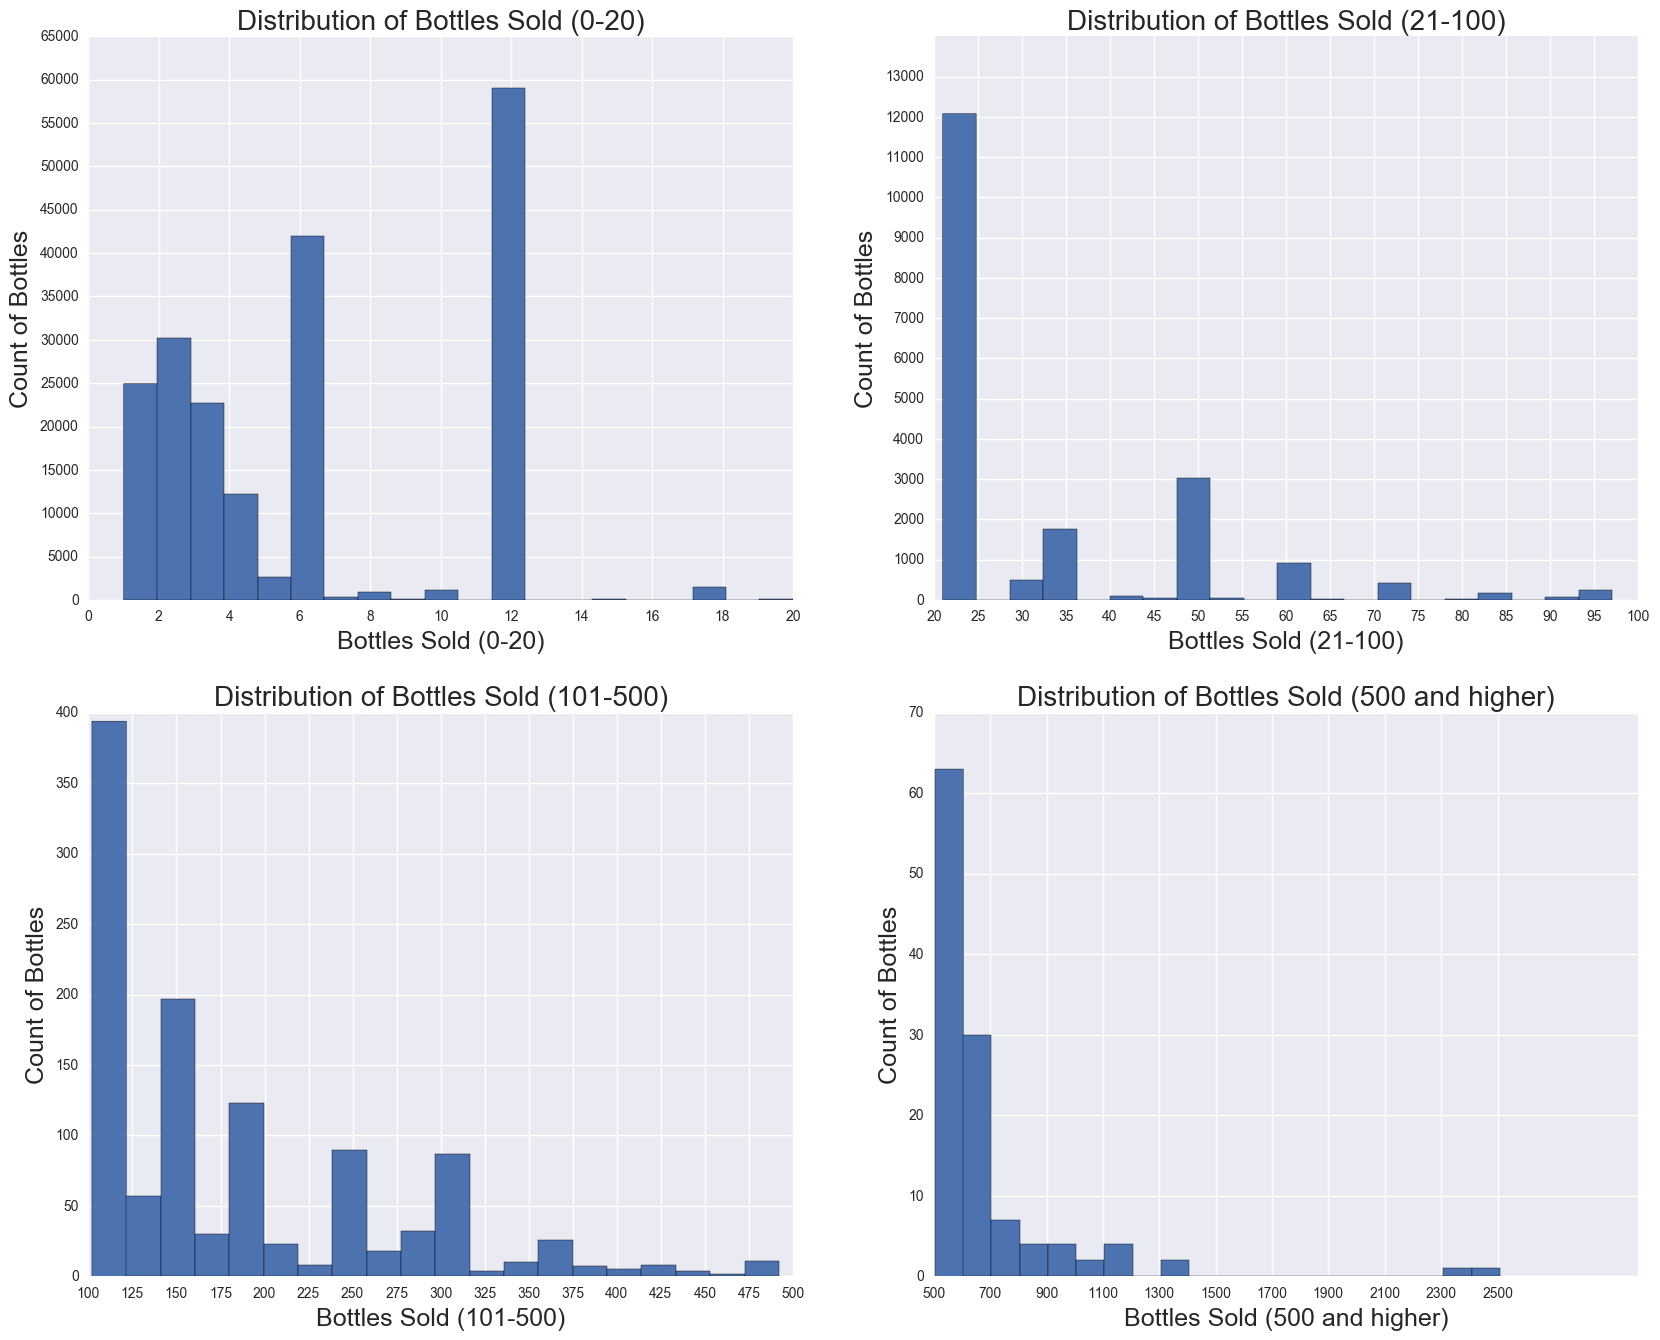

In [24]:
#evaluating bottles sold
fig, axes = plt.subplots(2,2, figsize=(20,16))
#Bottles Sold less than or equal to 10
axes[0][0].hist(x = df[df['Bottles Sold']<=20]['Bottles Sold'],bins = 20) 
axes[0][0].xaxis.set_ticks(np.arange(0, 21, 2))
axes[0][0].yaxis.set_ticks(np.arange(0, 70000, 5000))
axes[0][0].set_title('Distribution of Bottles Sold (0-20)',fontsize = 20)
axes[0][0].set_xlabel('Bottles Sold (0-20)',fontsize = 18)
axes[0][0].set_ylabel('Count of Bottles',fontsize = 18)
#Bottles Sold more than 10 and less than or equal to 100
axes[0][1].hist(x = df[(df['Bottles Sold']>20) & (df['Bottles Sold']<=100)]['Bottles Sold'],bins = 20)
axes[0][1].xaxis.set_ticks(np.arange(20, 101, 5))
axes[0][1].yaxis.set_ticks(np.arange(0, 14000, 1000))
axes[0][1].set_title('Distribution of Bottles Sold (21-100)',fontsize = 20)
axes[0][1].set_xlabel('Bottles Sold (21-100)',fontsize = 18)
axes[0][1].set_ylabel('Count of Bottles',fontsize = 18)
#Bottles Sold more than 100 and less than or equal to 500
axes[1][0].hist(x = df[(df['Bottles Sold']>100) & (df['Bottles Sold']<=500)]['Bottles Sold'],bins=20)
axes[1][0].xaxis.set_ticks(np.arange(100, 501, 25))
axes[1][0].set_title('Distribution of Bottles Sold (101-500)',fontsize = 20)
axes[1][0].set_xlabel('Bottles Sold (101-500)',fontsize = 18)
axes[1][0].set_ylabel('Count of Bottles',fontsize = 18)
#Bottles Sold more than 500 and less than or equal to 2700
axes[1][1].hist(x = df[(df['Bottles Sold']>500) & (df['Bottles Sold']<=2700)]['Bottles Sold'],bins = 20)
axes[1][1].xaxis.set_ticks(np.arange(500, 2700, 200))
axes[1][1].set_title('Distribution of Bottles Sold (500 and higher)',fontsize = 20)
axes[1][1].set_xlabel('Bottles Sold (500 and higher)',fontsize = 18)
axes[1][1].set_ylabel('Count of Bottles',fontsize = 18);

Only considering bottles sold 25 and under, the summary statistics are shown below. While the data is still skewed for Bottles Sold and Sale (Dollars), one standard deviation from the mean will not result in negative Bottles Sold and Sale (Dollars).

In [25]:
df[df['Bottles Sold'] < 26].describe()

,Store Number,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Total_Cost,Volume Sold (Liters),Volume Sold (Gallons)
count,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000
mean,3574.938144,256.002700,45987.777961,929.189392,9.843098,14.782341,7.226535,95.188922,63.379533,6.514019,1.721002
std,939.637685,141.524039,51971.895717,489.957932,7.044169,10.565687,5.912067,93.631837,62.388880,5.806351,1.533946
min,2106.000000,10.000000,173.000000,50.000000,0.890000,1.340000,1.000000,1.340000,0.890000,0.100000,0.030000
25%,2603.000000,115.000000,26828.000000,750.000000,5.720000,8.630000,2.000000,29.980000,19.980000,1.500000,0.400000
50%,3713.000000,260.000000,38178.000000,750.000000,8.200000,12.300000,6.000000,67.470000,44.970000,4.500000,1.190000
75%,4345.000000,380.000000,64676.000000,1000.000000,11.960000,17.940000,12.000000,129.120000,86.040000,10.500000,2.770000
max,9013.000000,978.000000,995507.000000,6000.000000,425.000000,637.500000,25.000000,3712.500000,2475.000000,150.000000,39.630000


### Unique Items per Store
By creating unique items per store, we can use it as a proxy for store size, which will one of the predictors used in the regression. The histogram for unique per items shows that it is skewed.

(1372, 2)
The mean # of unique items per store is 97.4774052478
The max # of unique items per store is 739
The min # of unique items per store is 1
The median # of unique items per store is 52.0


,Store Number,Unique_Items
0,2106,248
1,2113,94
2,2130,207
3,2152,71
4,2178,184


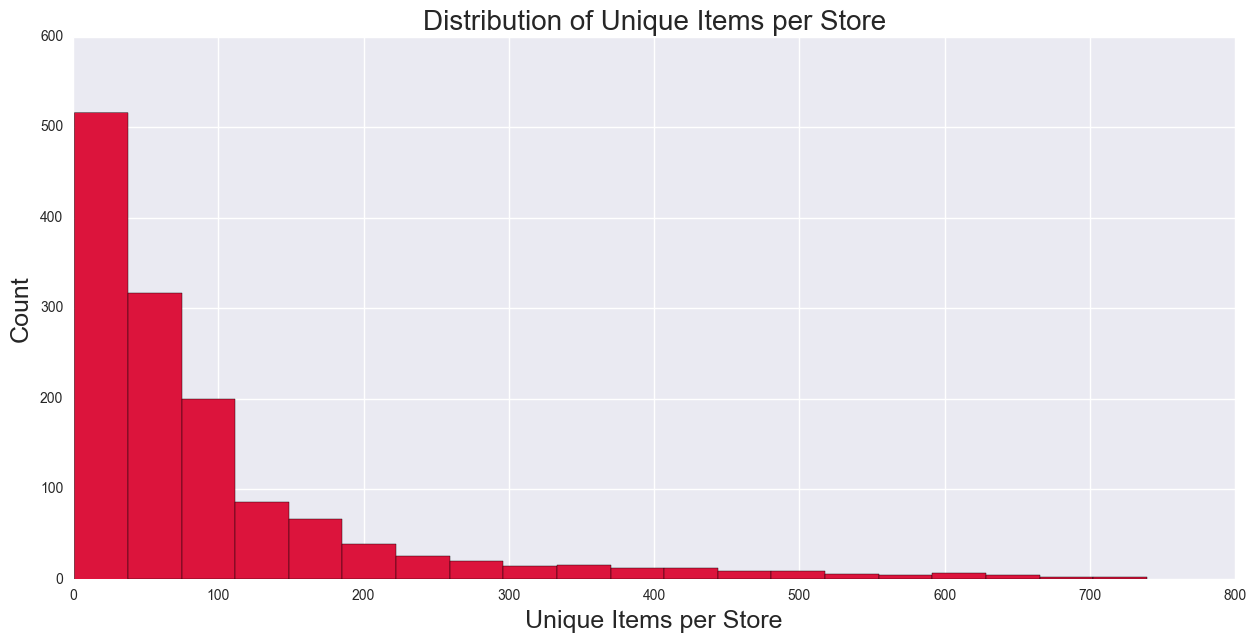

In [27]:
#creating unique items per store - possible proxy for sq footage given more items per store means a bigger store
#assumption is that that if an item did not sell, the business would remove them from the shelves, each business would maximize revenues
unique_items_per_store = df.groupby('Store Number')['Item Number'].nunique().to_frame('Unique_Items')
unique_items_per_store.reset_index(inplace = True)
unique_items_per_store.sort_values('Unique_Items',ascending = False)
print unique_items_per_store.shape
print "The mean # of unique items per store is", unique_items_per_store['Unique_Items'].mean()
print "The max # of unique items per store is", unique_items_per_store['Unique_Items'].max()
print "The min # of unique items per store is", unique_items_per_store['Unique_Items'].min()
print "The median # of unique items per store is", unique_items_per_store['Unique_Items'].median()

unique_items_per_store['Unique_Items'].hist(bins = 20, figsize = (15,7), color = 'crimson')
plt.title('Distribution of Unique Items per Store',fontsize = 20)
plt.xlabel('Unique Items per Store',fontsize = 18)
plt.ylabel('Count',fontsize = 18)
ax = plt.gca()
unique_items_per_store.head()

Calculating the Number of Stores per City, which will be used for number of competitors as a predictor in the regression. From the histogram, the distribution is heavily skewed.

### Average Items per Store per City
Calculating Average Items per Store per City and Sales per Store, which will be used later in merges. Histogram shows that there is a skewed distribution.

In [30]:
county_demo = pd.read_csv('../Resources/IA_Data_Master.csv')

In [172]:
city_store = df.groupby(['City','Store Number'])['Zip Code'].nunique().to_frame('Count')
city_store.reset_index(inplace = True)
city_items = pd.merge(city_store,unique_items_per_store)
city_avgitems = city_items.groupby('City')['Unique_Items'].mean().to_frame('Average_items_store')
city_avgitems.reset_index(inplace = True)
sales_per_store = df[df['Bottles Sold'] < 26].groupby('Store Number')['Sale (Dollars)'].sum().to_frame()
sales_per_store.reset_index(inplace = True)

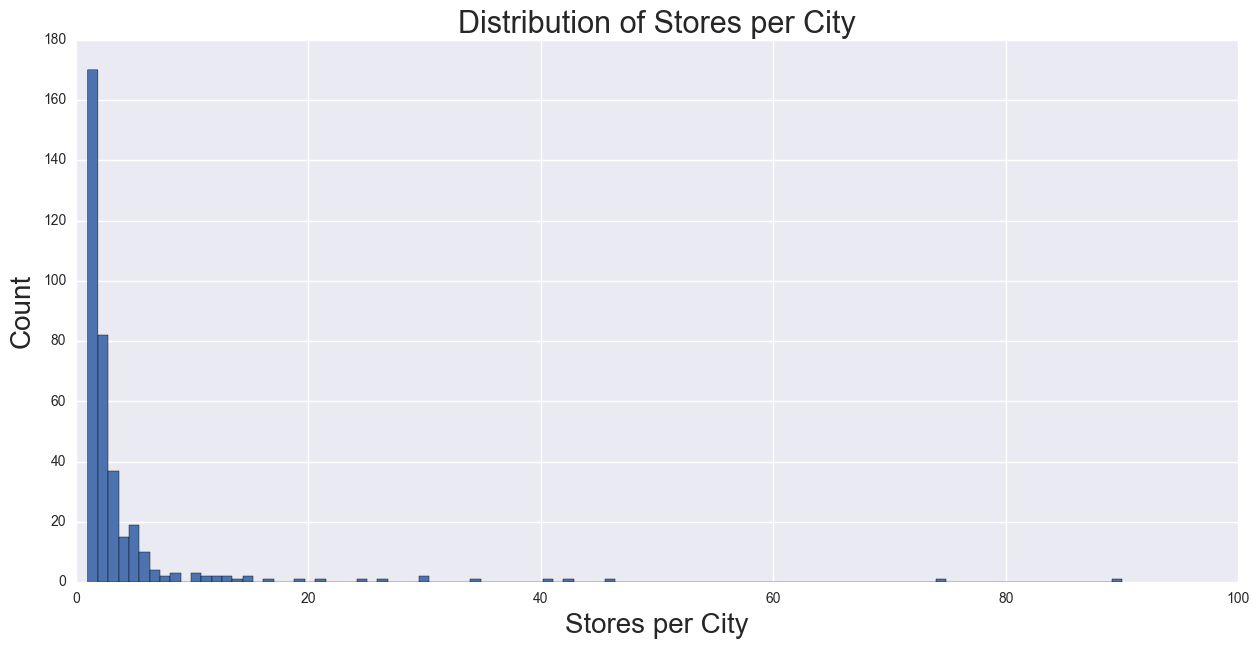

In [162]:
#creating stores per zip/city/county.
stores_per_city = df.groupby('City')['Store Number'].nunique().to_frame('Stores_per_City')
stores_per_city.reset_index(inplace = True)

stores_per_city.hist(figsize = (15,7),bins = 100)
#Stores per City is skewed
plt.title('Distribution of Stores per City',fontsize = 22)
plt.xlabel('Stores per City',fontsize = 20)
plt.ylabel('Count',fontsize = 20);

Starting from the df (original) dataframe, and merging with various dataframes created prior, a dataframe is created to build metrics to be used as predictors for the regression, which are the following:
* Bottles Sold
* Items per Store
* Average Price
* Stores per City
* Population

These predictors will be created from the df dataframe as well as external sources. The code below is the process for constructing these predictors.

#### 2015 Population by City

From the distribution of the histogram, Population by City is heavily skewed.

The mean of Population by City is: Population    2630.0
dtype: float64
The standard deviation of Population by City is: Population    11223.0
dtype: float64
Moving one standard deviation away from the mean would result in negative population, thus population is skewed


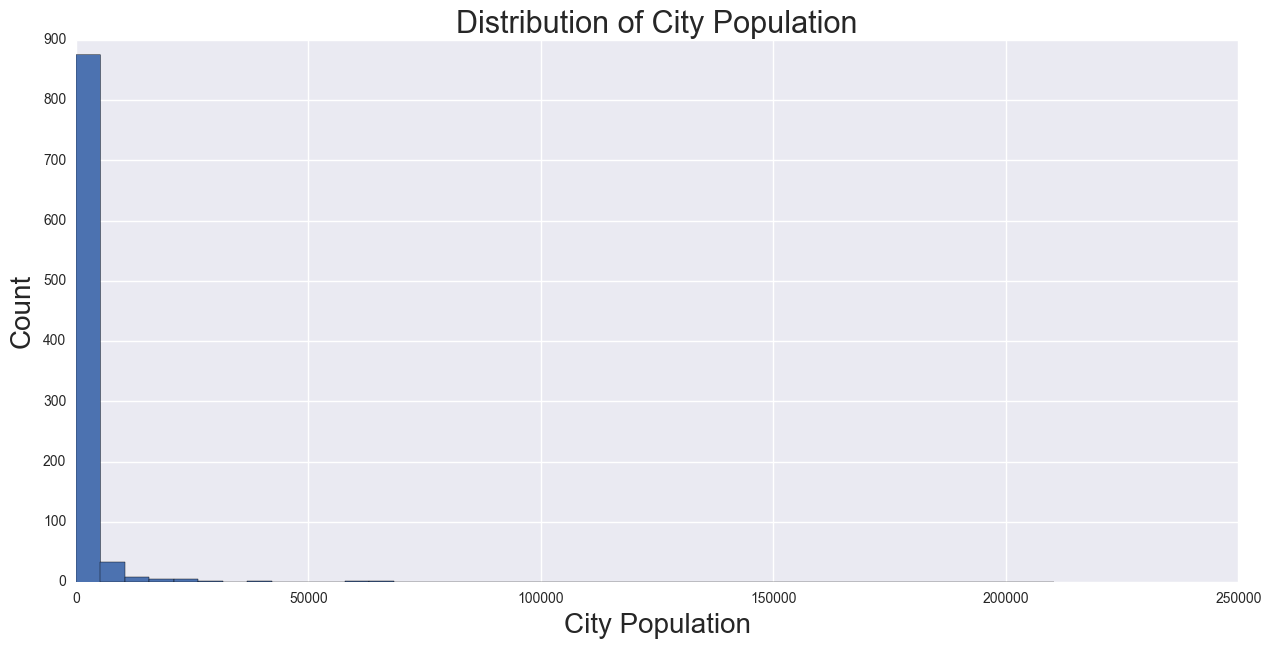

In [180]:
#Iowa population by City for 2015 from http://www.iowadatacenter.org/
city_pop_2015 = pd.read_csv('../Resources/IA_pop_2015.csv')
city_pop_2015.head()
city_pop_2015['City'] = city_pop_2015['City'].apply(lambda x: x.upper())

city_pop_2015.hist(figsize = (15,7),bins = 40)
plt.title('Distribution of City Population',fontsize = 22)
plt.xlabel('City Population',fontsize = 20)
plt.ylabel('Count',fontsize = 20);
print 'The mean of Population by City is:',city_pop_2015.mean().round(0)
print 'The standard deviation of Population by City is:',city_pop_2015.std().round(0)
print 'Moving one standard deviation away from the mean would result in negative population, thus population is skewed'

#### Categorizing the types of Liquor in the Data
By Categorizing the store name by whether it is a Liquor, Grocery, or Other, we can analyze the type of stores for the top 10 markets.

In [247]:
#categorizing each store number as Liquor, Grocery, or Other
store_names = pd.read_csv('../Resources/IA_Data_Stores.csv')
city_store = df.groupby(['Store Number','City'])['County'].nunique().to_frame()
city_store.reset_index(inplace = True)
total_citystore = pd.merge(city_store,store_names,on='Store Number')
store_type = []
liquor_list = []
grocery_list = []
other_list = []
liquor = ['liquor','spirits','wine','beverage','bottle','vineyard','beer','cellar','holler','distribution','central city','distributing']
grocery = ['hy-vee','fareway','target','wal-mart','food','supermarket',"dahl's","sam's club",'econ-o-mart','super valu','shop n save','grocery','pantry','costco','price chopper','save a lot']
for x in total_citystore['Store Name']:
    if any(word in x.lower() for word in liquor):
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    if any(word in x.lower() for word in grocery):
        store_type.append('Grocery')
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    else:
        store_type.append('Other')
        liquor_list.append(0)
        grocery_list.append(0)
        other_list.append(1)
total_citystore['Store Type'] = pd.Series(store_type)
total_citystore['Liquor'] = pd.Series(liquor_list)
total_citystore['Grocery'] = pd.Series(grocery_list)
total_citystore['Other'] = pd.Series(other_list)
#adding dummy variables to the dataframe and selecting those columns
total_citystore_merge = total_citystore.iloc[:,[0,1,3,4,5,6,7]]
#grouping by city and the dummy variables for store types.
city_storetype = total_citystore_merge.groupby('City')['Liquor','Grocery','Other'].sum()
city_storetype.reset_index(inplace = True)

## Regression Analysis 

The dataframe will be constructed to get the target (df_y) and the data for the predictors (df_X), which will then be split into train and test sets. The target variable is Bottles Sold. The predictors that will be used are the following:
#### Target Variable:
* Yearly Bottles Sold (per each Store)

#### Predictors:
* Items per Store
* Average Price
* Stores per City
* Population
* Per Capita Yearly Income

#### Assumptions and Constraints:
* Constraining the data to bottles sold per transaction to 25 and under
* Each store in a city is competing against each other
* Log-normalization due to the skewness of the target and predictors
* Per Capital Yearly Income, which is for county, is uniform across cities in the county

Linear Regression will be peformed on the training set, which will then be used to predict Bottles Sold. Before the regression is performed. Both the target and the predictors will be log-normalized because of the skewness, as shown in the histograms earlier.

In [202]:
#using store number to build the dataframe to be used for regression
store_bottles_df = df[df['Bottles Sold'] < 26].groupby(['Store Number','City'])[['Bottles Sold','Sale (Dollars)']].sum()
store_bottles_df.reset_index(inplace = True)
# merging with unique items per store, which will be used as a predictor
store_bottles_uniq_df = pd.merge(store_bottles_df,unique_items_per_store)
#merging with total competitors per city, which will be used as a predictor
store_df = pd.merge(store_bottles_uniq_df,stores_per_city)
# creating a column for average price, which will be used as a predictor
store_df['AvgPrice'] = store_df['Sale (Dollars)'] / store_df['Bottles Sold']
#merging with city population for 2015, which will be used as a predictor

store_df = pd.merge(store_df,city_pop_2015,how='left')

#creating a groupby to find Bottles Sold and Sale (Dollars) by City and merging with main dataframe
city_sales = store_df.groupby('City')[['Bottles Sold','Sale (Dollars)']].sum()
city_sales.reset_index(inplace = True)
city_sales = city_sales.rename(columns = {'Bottles Sold':'Bottles_City','Sale (Dollars)':'Sales_City'})
store_df = pd.merge(store_df,city_sales)
store_countypop = county_store.iloc[:,2:4]
store_df = pd.merge(store_df,store_countypop)
#creating dataframes for target and the predictors

df_y = np.log(store_df.iloc[:,2])
df_X = np.log(store_df.iloc[:,[4,5,6, 7,10]])

# splitting into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=.33)



Now that the data and target have been created, linear regression will be performed.

Linear Regression r^2 between Actual y and Predicted y_hat : 0.883641780803
MSE for Training Set: 0.171001810229
------------------------------------------------
The Predictors are: Unique_Items, Stores_per_City, AvgPrice, Population, Per Capita Yearly Income
Linear Regression Coefficients are: [ 0.98024988 -0.06530087 -0.22668026  0.09414212  0.05484093]
A 1% change in Unique_Items results in 0.98% change in Bottles Sold
A 1% change in Stores_per_City is: -0.06% change in Bottles Sold
A 1% change in AvgPrice is: -0.23% change in Bottles Sold
A 1% change in Population is: 0.09% change in Bottles Sold
A 1% change in Per Capita Yearly Income is: 0.05% change in Bottles Sold
------------------------------------------------
Test Training Set:
The r^2 on the test data is: 0.868574683994
MSE for Test Set: 0.190111731029


,Store Number,City,Bottles Sold,Sale (Dollars),Unique_Items,Stores_per_City,AvgPrice,Population,Bottles_City,Sales_City,Per Capita Yearly Income,Pred_Bottles
0,2106,CEDAR FALLS,5393,81026.24,248,17,15.024335,41255,29003,399731.96,24273,2549.911511
1,2572,CEDAR FALLS,5445,76956.87,739,17,14.133493,41255,29003,399731.96,24273,7539.974959
2,2835,CEDAR FALLS,760,11303.42,73,17,14.872921,41255,29003,399731.96,24273,770.696363
3,3769,CEDAR FALLS,3402,47338.44,139,17,13.914885,41255,29003,399731.96,24273,1470.977849
4,3995,CEDAR FALLS,2210,34036.77,98,17,15.401253,41255,29003,399731.96,24273,1020.525817


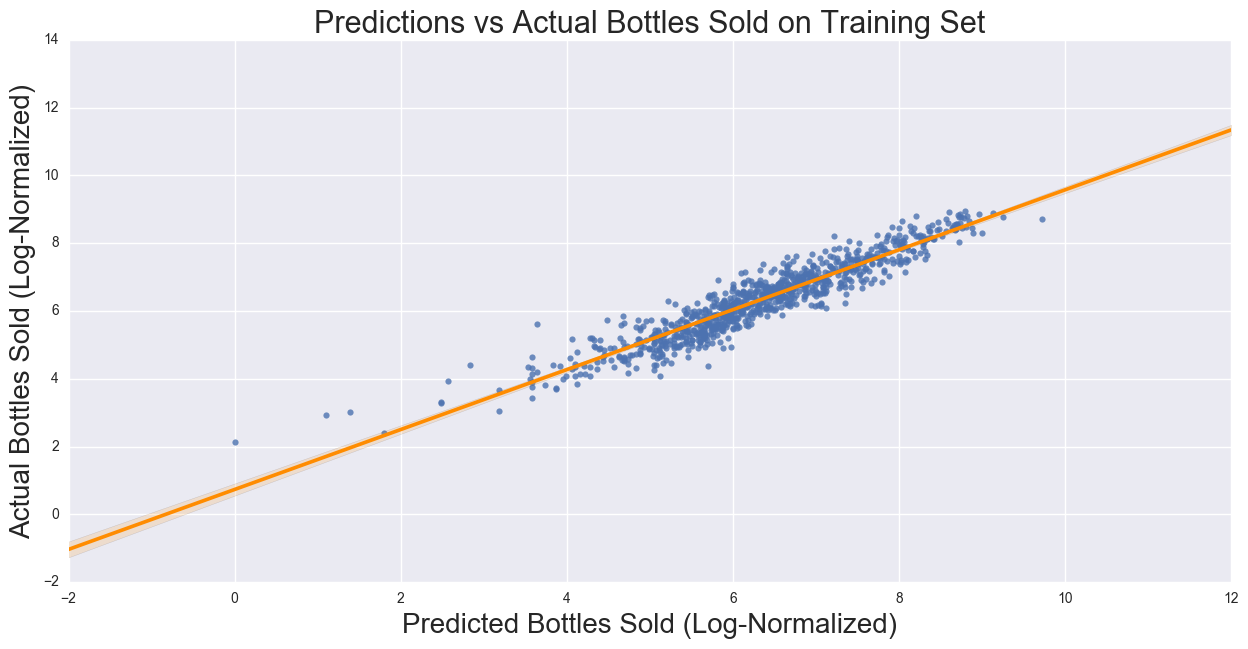

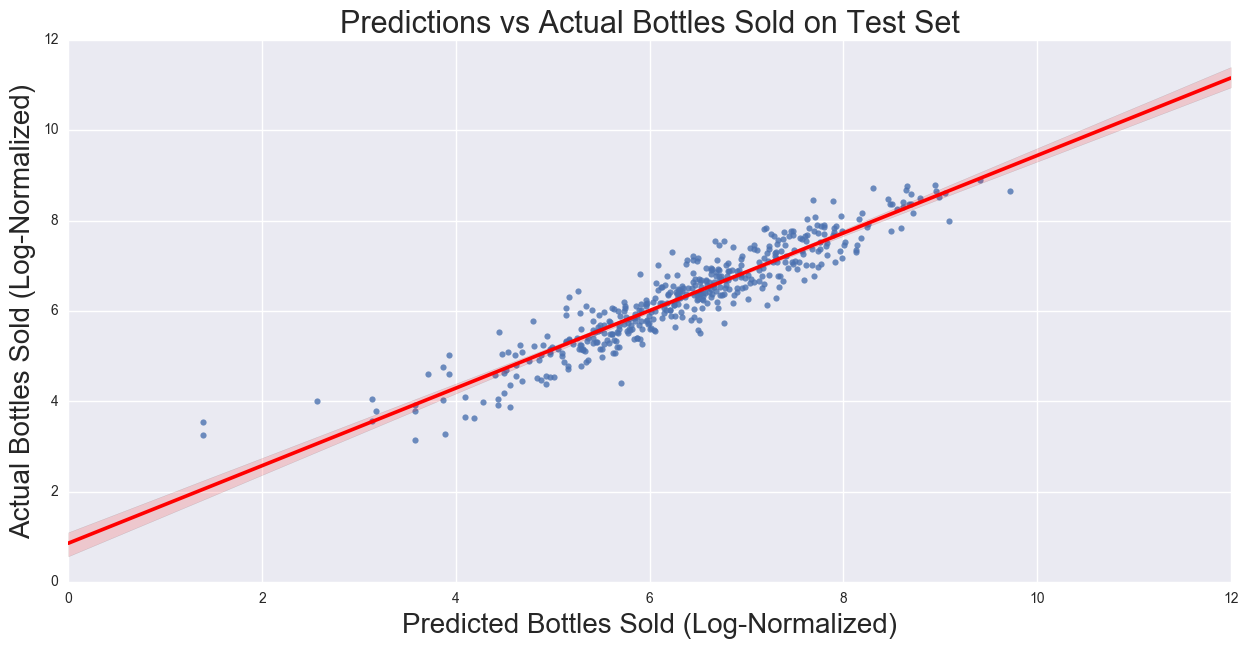

In [254]:
#loading necessary methods
from sklearn import linear_model
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.cross_validation import cross_val_predict,cross_val_score

#using linear regression
lr = linear_model.LinearRegression()

#fitting and predicting the model
lr_model = lr.fit(X_train,y_train)
lr_predict = lr.predict(X_train)
#computing the r-squared
lr_r2 =  r2_score(y_true=y_train, y_pred=lr_predict)
print 'Linear Regression r^2 between Actual y and Predicted y_hat :',lr_r2
print 'MSE for Training Set:',mean_squared_error(y_train,lr_predict)
print '------------------------------------------------'
print 'The Predictors are: {}, {}, {}, {}, {}'.format(df_X.columns[0],df_X.columns[1],df_X.columns[2],df_X.columns[3],df_X.columns[4])
print 'Linear Regression Coefficients are:',lr_model.coef_
print 'A 1% change in {} results in {}% change in Bottles Sold'.format(df_X.columns[0], (((1.01**lr_model.coef_[0])-1)*100).round(2))
print 'A 1% change in {} is: {}% change in Bottles Sold'.format(df_X.columns[1], (((1.01**lr_model.coef_[1])-1)*100).round(2))
print 'A 1% change in {} is: {}% change in Bottles Sold'.format(df_X.columns[2], (((1.01**lr_model.coef_[2])-1)*100).round(2))
print 'A 1% change in {} is: {}% change in Bottles Sold'.format(df_X.columns[3], (((1.01**lr_model.coef_[3])-1)*100).round(2))
print 'A 1% change in {} is: {}% change in Bottles Sold'.format(df_X.columns[4], (((1.01**lr_model.coef_[4])-1)*100).round(2))
plt.figure(figsize = (15,7))
sns.regplot(y_train,lr_predict,line_kws = {'color':'darkorange'})
plt.title('Predictions vs Actual Bottles Sold on Training Set',fontsize = 22)
plt.xlabel('Predicted Bottles Sold (Log-Normalized)',fontsize = 20)
plt.ylabel('Actual Bottles Sold (Log-Normalized)',fontsize = 20)
print '------------------------------------------------'
print "Test Training Set:"
y_test_predict = lr.predict(X_test)
test_linear_r2 =  r2_score(y_true=y_test, y_pred=lr.predict(X_test))
print 'The r^2 on the test data is:',test_linear_r2
print 'MSE for Test Set:',mean_squared_error(y_test,y_test_predict)
#model fits on test data


plt.figure(figsize = (15,7))
sns.regplot(y_test,y_test_predict,line_kws = {'color':'red'})
plt.title('Predictions vs Actual Bottles Sold on Test Set',fontsize = 22)
plt.xlabel('Predicted Bottles Sold (Log-Normalized)',fontsize = 20)
plt.ylabel('Actual Bottles Sold (Log-Normalized)',fontsize = 20)
dfy_predict = lr.predict(df_X)
store_df['Pred_Bottles'] = np.exp(dfy_predict)
store_df.head()

#### Analysis of the Results
The correlation on the training dataset is 0.88. The coefficients for the regression show the strongest predictor is  Unique Items (positively correlated), followed by Average Price (negatively correlated), Stores per City/Number of competition (negatively correlated), and Population and Per Capital Yearly Income (both positively correlated). These relationships are what we expect to see: the number of items in a store would show that more available products to purchase, and as the number of competitors in the city as well as price should decrease the bottles sold. Population and Income should be positively correlated as the more people are in a city, the higher demand should be, and the more disposable income a person has, the more the person is able to spend on liquor. If the assumption of the Yearly per Capita Income is uniformly distributed across all cities in the county does not hold, then there would be a stronger bias, which requires city level Yearly per Capital Income.

What happens if another store enters the market? Assuming Quantity (Bottles Sold per City) and Avg Price does not change (also means Total Sales (Dollars) per city does not change), if we increased number of stores per city by 1, we can calculate the new AvgSales with entry of a new store. Sorting from highest to lowest, we will find top 10 cities as consideration for markets to expand.

Once we know which markets to enter, we can find the average number of items among the competitors,types of competitors, and also the items and prices to which we place in the store.

Mean of Average Items/Store in the Top 10 Cities is: 164.0
The following cities are either suburbs (Windsor Heights, Bettendorf, Coralville), college towns 
 (Mt. Vernon, Iowa City, Cedar Falls), or near a resort/lake (Spirit Lake, Milford, Mason City)

The store type has been incorporated to show the types of stores in a given city


,City,Total Sales (Dollars),Number of Stores,Number of Stores + 1,AvgSales,AvgSales_w_entry,Delta Sales%,Population,Liquor,Grocery,Other,Average_items_store
0,MT VERNON,130172.81,3.0,4.0,43390.936667,32543.202500,-0.250000,4486,1,0,2,178.666667
1,WINDSOR HEIGHTS,198687.11,6.0,7.0,33114.518333,28383.872857,-0.142857,4889,1,2,3,199.000000
2,MILFORD,84245.46,2.0,3.0,42122.730000,28081.820000,-0.333333,3018,0,2,0,241.000000
3,BETTENDORF,343749.94,12.0,13.0,28645.828333,26442.303077,-0.076923,35505,2,2,8,132.416667
4,IOWA CITY,670082.63,26.0,27.0,25772.408846,24817.875185,-0.037037,74220,3,7,16,151.615385
5,MASON CITY,314249.36,13.0,14.0,24173.027692,22446.382857,-0.071429,27366,3,5,5,155.692308
6,CLINTON,245612.03,10.0,11.0,24561.203000,22328.366364,-0.090909,26064,0,5,5,136.200000
7,SPIRIT LAKE,155668.34,6.0,7.0,25944.723333,22238.334286,-0.142857,5018,1,0,5,147.500000
8,CEDAR FALLS,399731.96,17.0,18.0,23513.644706,22207.331111,-0.055556,41255,2,4,11,163.882353
9,CORALVILLE,308774.21,13.0,14.0,23751.862308,22055.300714,-0.071429,20608,0,7,6,137.384615


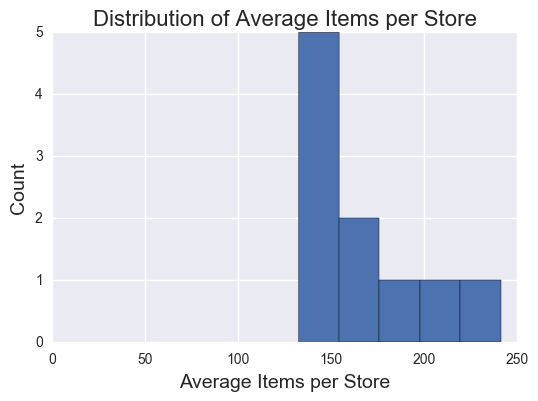

In [249]:
city_sales = store_df.groupby('City')['Sale (Dollars)'].agg({len,sum})
city_sales.reset_index(inplace = True)
city_sales = city_sales.rename(columns = {'sum':'Total Sales (Dollars)','len':'Number of Stores'})
city_sales['Number of Stores + 1'] = city_sales['Number of Stores'] + 1
city_sales['AvgSales'] = city_sales['Total Sales (Dollars)'] / city_sales['Number of Stores']
city_sales['AvgSales_w_entry'] = city_sales['Total Sales (Dollars)']/city_sales['Number of Stores + 1']
city_sales['Delta Sales%'] = (city_sales['AvgSales_w_entry']-city_sales['AvgSales'])/city_sales['AvgSales']


top10_cities = city_sales.sort_values('AvgSales_w_entry',ascending = False).head(10)
top10_cities = pd.merge(top10_cities,city_pop_2015)
#merging with store types from the code in the cell below
top10_cities = pd.merge(top10_cities,city_storetype)
#bringing in average items per city
top10_cities = pd.merge(top10_cities,city_avgitems)
top10_cities['Average_items_store'].hist(bins = 5)
plt.title('Distribution of Average Items per Store',fontsize = 16)
plt.xlabel('Average Items per Store',fontsize = 14)
plt.ylabel('Count',fontsize = 14)
plt.xlim(0,250)
Avg_item_top10 = top10_cities['Average_items_store'].mean().round()
print 'Mean of Average Items/Store in the Top 10 Cities is:',Avg_item_top10

print "The following cities are either suburbs (Windsor Heights, Bettendorf, Coralville), college towns \n (Mt. Vernon, Iowa City, Cedar Falls), or near a resort/lake (Spirit Lake, Milford, Mason City)"
print ''
print 'The store type has been incorporated to show the types of stores in a given city'
top10_cities

The following cities are either subarbs (Windsor Heights, Bettendorf, Coralville), college towns (Mt. Vernon, Iowa CityCedar Falls, or near a resort/lake (Spirit Lake, Milford, Mason City). Categorizing the Category Name to bins of liquor types, we can find the ideal mix of inventory using the average items per store, which was calculated above (164 items per store)

In [220]:
#make all category names upper case
#create category bins to be used for portfolio
df['Category Name'] = df['Category Name'].apply(lambda x: str(x).upper())
category = df.groupby('Category Name')['Item Number'].nunique().to_frame()
category.reset_index(inplace = True)
#creating category bins 
items = df.copy()
cat_bins = []
for x in items['Category Name']:
    if 'VODKA' in x:
        cat_bins.append('VODKA')
    elif 'WHISKEY' in x:
        cat_bins.append('WHISKEY')
    elif 'WHISKIES' in x:
        cat_bins.append('WHISKEY')
    elif 'RUM' in x:
        cat_bins.append('RUM')
    elif 'SCHNAPPS' in x:
        cat_bins.append('SCHNAPPS')
    elif 'BRANDIES' in x:
        cat_bins.append('BRANDIES')    
    elif 'GIN' in x:
        cat_bins.append('GIN') 
    elif 'SCOTCH' in x:
        cat_bins.append('SCOTCH') 
    elif 'BOURBON' in x:
        cat_bins.append('BOURBON')
    elif 'AMARETTO' in x:
        cat_bins.append('AMARETTO')         
    elif 'TEQUILA' in x:
        cat_bins.append('TEQUILA') 
    else:
        cat_bins.append('OTHER')
#setting a new column called cat_bins where it is categories of each type of liquor sold
items['cat_bins'] = cat_bins
print 'The OTHER Category represents:',items[items['cat_bins'] == 'OTHER']['Category Name'].unique()
#only looking at the top 10 cities chosen
top10_city_df = top10_cities.iloc[:,0].to_frame()
items_top10 = pd.merge(items,top10_city_df)
#grouping by city we see the total amount of liquor sold per category
categories_top10 = items_top10.groupby(['City','cat_bins'])['Bottles Sold'].agg({len,sum})
categories_top10.reset_index(inplace = True)

#finding total bottles sold per city
bottles_sold_top10 = categories_top10.groupby('City')['sum'].sum().to_frame()
bottles_sold_top10.reset_index(inplace = True)

#merging with categories we can show the % of category of liquor sold per each city
category_mix_top10 = pd.merge(categories_top10,bottles_sold_top10,on='City')
category_mix_top10 = category_mix_top10.rename(columns = {'sum_x':'Bottles_cat','sum_y':'City_Bottles_cat'})
category_mix_top10['PCT'] = category_mix_top10['Bottles_cat'] / category_mix_top10['City_Bottles_cat']

#what about what is the highest mix of categories out of all the top10?
category_mix_total = category_mix_top10.groupby('cat_bins')['Bottles_cat'].sum().to_frame()
category_mix_total.reset_index(inplace = True)
category_mix_total['PCT'] = category_mix_total['Bottles_cat'] / category_mix_total['Bottles_cat'].sum()
category_mix_total = category_mix_total.rename(columns = {'Bottles_cat':'Total_Bottles_cat'})
category_mix_total.sort_values('PCT',ascending = False)

#Vodka, Whiskey, and Rum are the top 3 types of liquor. 
#The average items per store for top 10 is 164.
#Assuming this would be the size of the store, lets multiply the percentages times 164
category_mix_total['Ideal_Mix_Qty'] = (category_mix_total['PCT'] * 164).round()
print '\n'
print 'The ideal mix of liquors, assuming 164 items per store,for a new store should be:'
print category_mix_total.iloc[:,[0,3]]
category_mix_top10

The OTHER Category represents: ['AMERICAN COCKTAILS' 'DISTILLED SPIRITS SPECIALTY'
 'MISC. AMERICAN CORDIALS & LIQUEURS' 'MISC. IMPORTED CORDIALS & LIQUEURS'
 'CREAM LIQUEURS' 'TRIPLE SEC' 'AMERICAN ALCOHOL' 'COFFEE LIQUEURS'
 'DECANTERS & SPECIALTY PACKAGES' 'REPOSADO' 'CREME DE ALMOND' 'ROCK & RYE'
 'WHITE CREME DE MENTHE' 'WHITE CREME DE CACAO' 'DARK CREME DE CACAO'
 'GREEN CREME DE MENTHE' 'NAN' 'ANISETTE' 'HIGH PROOF BEER - AMERICAN'
 'MOONSHINE']


The ideal mix of liquors, assuming 164 items per store,for a new store should be:
    cat_bins  Ideal_Mix_Qty
0   AMARETTO            1.0
1    BOURBON            0.0
2   BRANDIES            6.0
3        GIN            6.0
4      OTHER           18.0
5        RUM           21.0
6   SCHNAPPS            7.0
7     SCOTCH            1.0
8    TEQUILA            9.0
9      VODKA           49.0
10   WHISKEY           46.0


,City,cat_bins,Bottles_cat,len,City_Bottles_cat,PCT
0,BETTENDORF,AMARETTO,224,22,37030,0.006049
1,BETTENDORF,BOURBON,16,3,37030,0.000432
2,BETTENDORF,BRANDIES,850,120,37030,0.022954
3,BETTENDORF,GIN,1297,142,37030,0.035026
4,BETTENDORF,OTHER,4160,407,37030,0.112341
5,BETTENDORF,RUM,5024,331,37030,0.135674
6,BETTENDORF,SCHNAPPS,1809,156,37030,0.048852
7,BETTENDORF,SCOTCH,212,69,37030,0.005725
8,BETTENDORF,TEQUILA,2881,177,37030,0.077802
9,BETTENDORF,VODKA,11118,808,37030,0.300243


## Conclusion

Given the 10% random sample of the Iowa Liquor Sales, the log-normalized Linear Regression Model was used to fit the data to the model. Using the yearly Bottles Sold per each store as the target variables, the predictors Unique Items per Store, Stores per City, Avg Price, Population, and Income were used to fit the model. The correlation and MSE of the data was 0.88 and 0.17, respectively. The model was then used to predict on the test set, and comparing actual Bottles Sold to predicted Bottles Sold 0.87 and 0.19, respectively.

Top 10 Cities are recommended using Average Sales per number of competition, which is stores per city. Since we are interested in the scenario where a new store enters the market. We add 1 to the stores per city and divide Avg Sales by this number. Also assumed was that avg price and bottles sold per city were constant. The following cities are recommended for new markets for a new store location: Mt Vernon, Windsor Heights, Milford, Bettendorf, Iowa City, Mason City, Clinton, Spirit Lake, Cedar Falls, and Coralville. Using the types of Liquor sold (binning them into types), the ideal mix of products to be sold was calculated, which is based on the aggregate of top 10 cities. 

Further Analysis can be performed on the brand and size of each type of liquor, as well as the optimal price based on calculated price elasticities. 

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

## Plot Ideas

* Barchart of % of liquor stores compared to all stores
* Catergory Breakdown, average by county for key counties
* Barchart of percentage difference of Sales/(N+1) - Sales/N, and corresponding subsequent sales
* Barchart of # of categories vs sales -> Show how # of categories affects sales (So, use all data)
* 3 sets of graphs for comaprison; college towns, lake towns, suburb towns
  * Use descriptive metrics like barchart of liquors carried percentages
  * Bottle Counts
* Distribution of populations and store counts for cities that are recommended